In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sigmf
import pathlib

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

In [2]:
files = [sigmf.sigmffile.fromfile(str(f))
         for f in pathlib.Path('.').glob('*_32ksps.sigmf-data')]

In [3]:
samp_rate = files[0].get_global_field(sigmf.SigMFFile.SAMPLE_RATE_KEY)

In [4]:
t0 = np.datetime64(files[0].get_capture_info(0)[sigmf.SigMFFile.DATETIME_KEY].replace('Z', ''), 'ns')
t1 = np.datetime64(files[1].get_capture_info(0)[sigmf.SigMFFile.DATETIME_KEY].replace('Z', ''), 'ns')
t0_end = t0 + (files[0].read_samples().size / samp_rate * 1e9) * np.timedelta64(1, 'ns')
gap = t1 - t0_end
gap_samples = int(np.round(gap / np.timedelta64(1, 's') * samp_rate))

In [5]:
x = np.concatenate((files[0].read_samples(), np.full(gap_samples, np.nan, 'complex64'), files[1].read_samples()))

In [6]:
NFFT = 2**13
w = np.blackman(NFFT)
wat = np.fft.fftshift(np.abs(np.fft.fft(w * x[:x.size//NFFT*NFFT].reshape(-1, NFFT)))**2,
                      axes=1)

faxis = np.fft.fftshift(np.fft.fftfreq(NFFT, 1/samp_rate))
fsel = (faxis >= -2.5e3) & (faxis <= 0)

In [7]:
dummy_load_cal_start = np.average(wat[:55,])
dummy_load_cal_end = np.average(wat[-25:,])
dummy_load_cal_start, dummy_load_cal_end

(0.007310952236940047, 0.0067249588923343736)

In [8]:
10*np.log10(dummy_load_cal_start) - 10*np.log10(dummy_load_cal_end)

0.3628431266155623

In [9]:
dummy_load_cal = 0.5 * (dummy_load_cal_start + dummy_load_cal_end)
wat_cal = wat / dummy_load_cal

In [10]:
tstep = NFFT / samp_rate
n = x.size // NFFT
taxis = t0 + np.arange(n) * ((1e9 * tstep) * np.timedelta64(1, 'ns'))

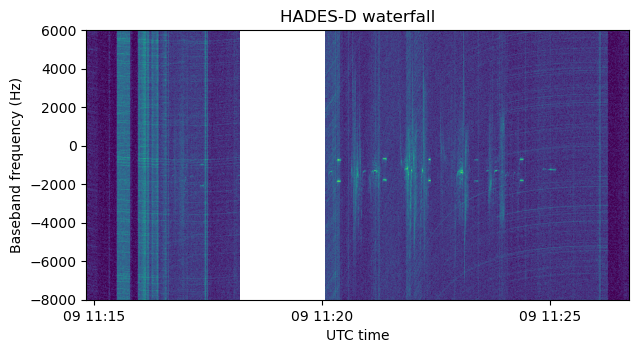

In [11]:
fsel_wide = (faxis >= -8e3) & (faxis <= 6e3)
a = mdates.date2num(taxis[0])
b = mdates.date2num(taxis[-1])
plt.imshow(10*np.log10(wat_cal[:, fsel_wide].T[::-1]), aspect='auto',
          extent=[a, b, faxis[fsel_wide][0], faxis[fsel_wide][-1]], vmin=-5, vmax=25)
plt.gca().xaxis_date()
plt.title('HADES-D waterfall')
plt.xlabel('UTC time')
plt.ylabel('Baseband frequency (Hz)');

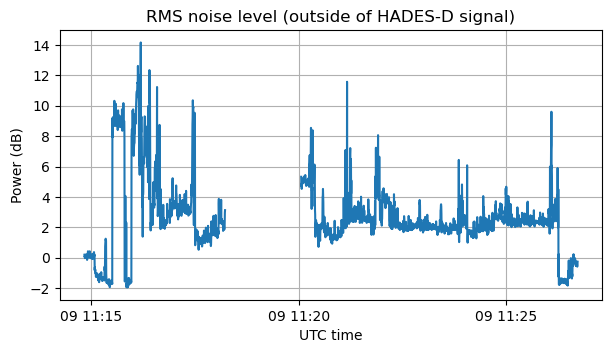

In [12]:
wb_noise = (np.sum(wat_cal, axis=1) - np.sum(wat_cal[:, fsel_wide], axis=1)) / (wat_cal.shape[1] - np.sum(fsel_wide))
plt.plot(taxis, 10*np.log10(wb_noise))
plt.grid()
plt.title('RMS noise level (outside of HADES-D signal)')
plt.ylabel('Power (dB)')
plt.xlabel('UTC time');

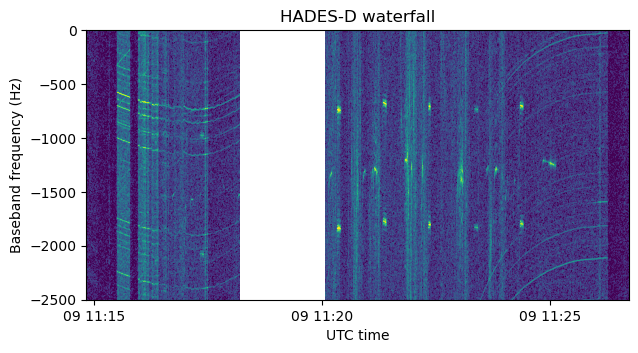

In [13]:
a = mdates.date2num(taxis[0])
b = mdates.date2num(taxis[-1])
plt.imshow(10*np.log10(wat_cal[:, fsel].T[::-1]), aspect='auto',
          extent=[a, b, faxis[fsel][0], faxis[fsel][-1]], vmin=-5, vmax=25)
plt.gca().xaxis_date()
plt.title('HADES-D waterfall')
plt.xlabel('UTC time')
plt.ylabel('Baseband frequency (Hz)');

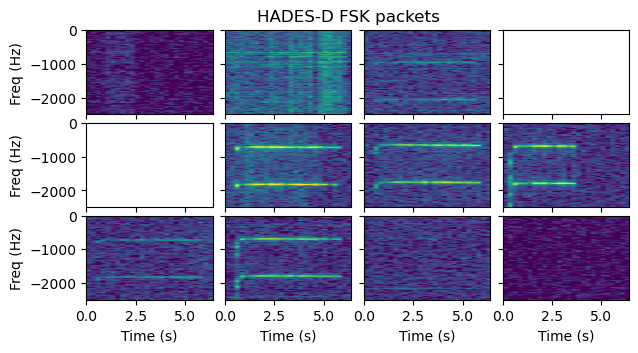

In [14]:
fsk_starts = np.int32(np.round(np.arange(113, wat_cal.shape[0], 60 / tstep)))
fsk_duration = 26
tfsk = np.arange(fsk_duration) * tstep
fig, axs = plt.subplots(3, 4, sharex=True, sharey=True)
for j, fsk_start in enumerate(fsk_starts):
    axs.ravel()[j].imshow(10*np.log10(wat_cal[fsk_start:fsk_start+fsk_duration, fsel].T[::-1]),
                          aspect='auto', vmin=-5, vmax=25,
                          extent=[0, tfsk[-1], faxis[fsel][0], faxis[fsel][-1]])

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.suptitle('HADES-D FSK packets', y=0.94)
for ax in axs[-1]:
    ax.set_xlabel('Time (s)')
for ax in axs.T[0]:
    ax.set_ylabel('Freq (Hz)')

In [15]:
good_fsk = [2, 5, 6, 7, 8, 9]

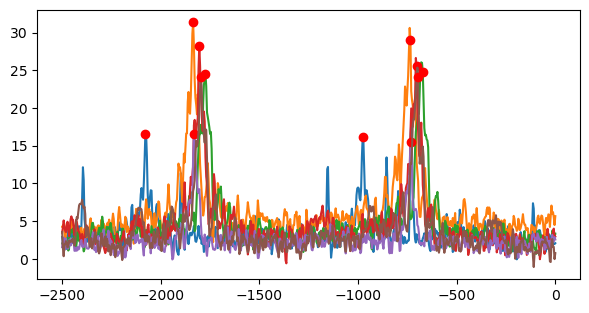

In [16]:
low_tone_freq = np.empty(len(good_fsk), 'int')
deviation = 550
high_tone_freq = np.empty(len(good_fsk), 'int')
for j, fsk_start in enumerate(fsk_starts[good_fsk]):
    spec = 10*np.log10(np.average(wat_cal[fsk_start:fsk_start+fsk_duration, fsel], axis=0))
    low_tone_freq[j] = np.argmax(spec[:spec.size//2])
    high_tone_freq[j] = low_tone_freq[j] + round(2 * deviation * NFFT / samp_rate)
    plt.plot(faxis[fsel], spec)
    plt.plot(faxis[fsel][low_tone_freq[j]], spec[low_tone_freq[j]], 'o', color='red')
    plt.plot(faxis[fsel][high_tone_freq[j]], spec[high_tone_freq[j]], 'o', color='red')

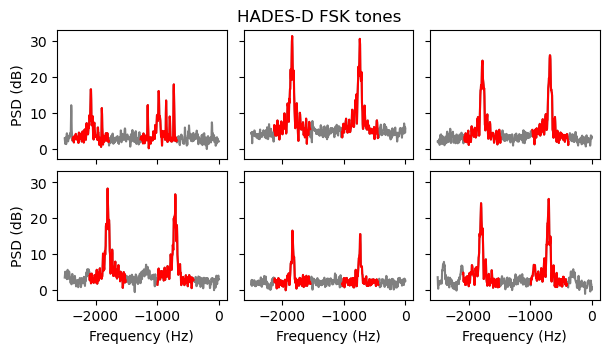

In [17]:
span = 75
nbins = 2 * (2 * span + 1)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
pwr_fsk = np.empty((len(good_fsk), fsk_duration))
cn0_fsk = np.empty((len(good_fsk), fsk_duration))
for j, fsk_start in enumerate(fsk_starts[good_fsk]):
    wt = wat_cal[fsk_start:fsk_start+fsk_duration, fsel]
    spec = 10*np.log10(np.average(wt, axis=0))
    ax = axs.ravel()[j]
    ax.plot(faxis[fsel], spec, color='grey')
    pwr_fsk[j] = 0
    for f in [low_tone_freq[j], high_tone_freq[j]]:
        ax.plot(faxis[fsel][f-span:f+span+1],
                spec[f-span:f+span+1], color='red')
        pwr_fsk[j] += np.sum(wt[:, f-span:f+span+1], axis=1)
    noise = np.sum(wt, axis=1) - pwr_fsk[j]
    noise = np.average(noise) / (wt.shape[1] - nbins)
    pwr_fsk[j] -= noise * nbins
    cn0_fsk[j] = pwr_fsk[j] / (noise / (samp_rate / NFFT))

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.suptitle('HADES-D FSK tones', y=0.94)
for ax in axs[-1]:
    ax.set_xlabel('Frequency (Hz)')
for ax in axs.T[0]:
    ax.set_ylabel('PSD (dB)')

/tmp/ipykernel_63597/3858876194.py:14: RuntimeWarning: invalid value encountered in log10
  axs.ravel()[j].plot(tfsk, 10*np.log10(cn0))


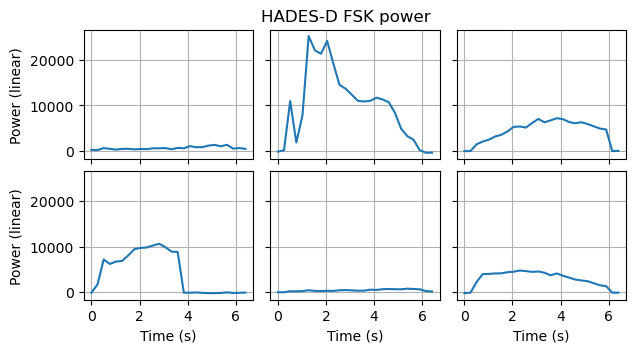

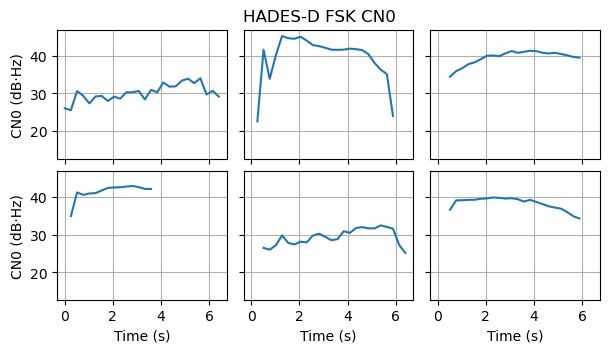

In [18]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
for j, pwr in enumerate(pwr_fsk):
    axs.ravel()[j].plot(tfsk, pwr)
    axs.ravel()[j].grid()
plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.suptitle('HADES-D FSK power', y=0.94)
for ax in axs[-1]:
    ax.set_xlabel('Time (s)')
for ax in axs.T[0]:
    ax.set_ylabel('Power (linear)')

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
for j, cn0 in enumerate(cn0_fsk):
    axs.ravel()[j].plot(tfsk, 10*np.log10(cn0))
    axs.ravel()[j].grid()
plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.suptitle('HADES-D FSK CN0', y=0.94)
for ax in axs[-1]:
    ax.set_xlabel('Time (s)')
for ax in axs.T[0]:
    ax.set_ylabel('CN0 (dB·Hz)')

In [19]:
noise_figure = 5  # assumed noise figure of 5 dB for the USRP B205mini
power_dummy_load = 10**(0.1*(-174 + noise_figure)) * samp_rate / NFFT
power_dummy_load

4.917677389820941e-17

/tmp/ipykernel_63597/846569237.py:3: RuntimeWarning: invalid value encountered in log10
  axs.ravel()[j].plot(tfsk, 10*np.log10(pwr * power_dummy_load))


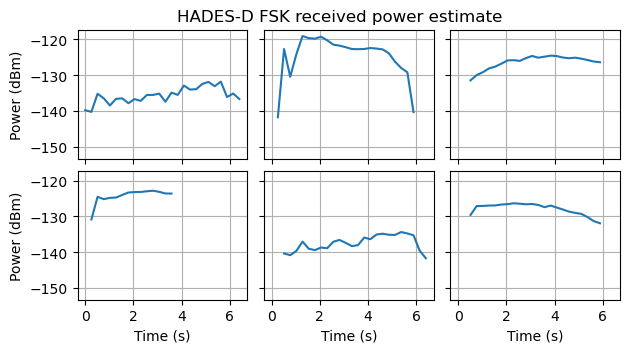

In [20]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
for j, pwr in enumerate(pwr_fsk):
    axs.ravel()[j].plot(tfsk, 10*np.log10(pwr * power_dummy_load))
    axs.ravel()[j].grid()
plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.suptitle('HADES-D FSK received power estimate', y=0.94)
for ax in axs[-1]:
    ax.set_xlabel('Time (s)')
for ax in axs.T[0]:
    ax.set_ylabel('Power (dBm)')

In [21]:
max_power = -120  # dBm
distance = 569e3  # m
freq = 436.666e6  # Hz
path_loss = 20*np.log10(distance) + 20*np.log10(freq) - 147.55  # dB
antenna_gain = 12  # dBi (7 element yagi, includes some pointing error)
eirp = max_power - antenna_gain + path_loss  # dBm
eirp

8.355232885713122